<h1>EDA of language and application of Prophet for four companies<h1>

<h3>Import libraries<h3>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import os
import math
import warnings
from datetime import datetime
from collections import Counter

<h3> Import libraries for visualisation<h3>

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
#import multiprocessing as mp

<h3> Import Facebooks Prohet library<h3>

In [3]:
from fbprophet import Prophet

<h3>Read data into memory</h3>

In [4]:
df_train = pd.read_csv('C:/Users/matth/webtraffic/train_1.csv').fillna(0)

<h3>Convert columsn from float to integer</h3>

In [5]:
for col in df_train.columns[1:]:
    df_train[col] = pd.to_numeric(df_train[col], downcast='integer')

<h3>If webpage is a wikipedia page extract language from the web address</h3>

In [6]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res.group(0)[0:2]
    return 'na'

df_train['lang'] = df_train.Page.map(get_language)
languages = df_train.lang.unique()
print(Counter(df_train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


<h3>Create datasets of each languages websites daily visits</h3>

In [7]:
# Analyze language feature
lang_sets = {}
for language in languages:
    lang_sets[language] = df_train[df_train.lang == language].iloc[:, 0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:, 1:].sum(axis=0) / lang_sets[key].shape[0]
    
days = [r for r in range(sums['fr'].shape[0])]

<h3>Create dictionary to convert short version of lanaguage to full name</h3>

In [8]:
labels = {'en': 'English', 'ja': 'Japanese', 'de': 'German',
          'na': 'Media', 'fr': 'French', 'zh': 'Chinese',
          'ru': 'Russian', 'es': 'Spanish'}

<h3>Plot above data. Each languages set of websites daily visits</h3>

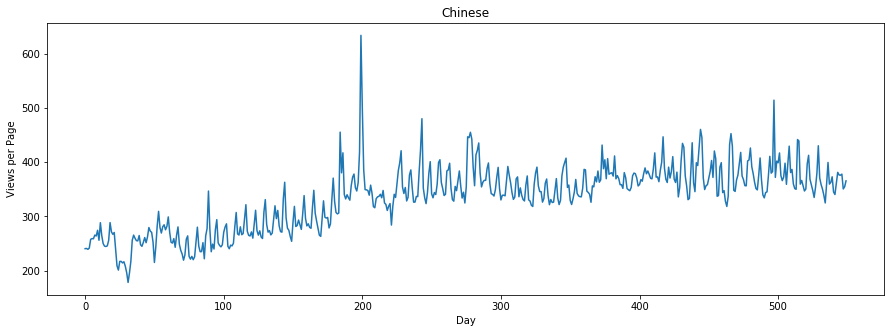

<Figure size 1080x360 with 0 Axes>

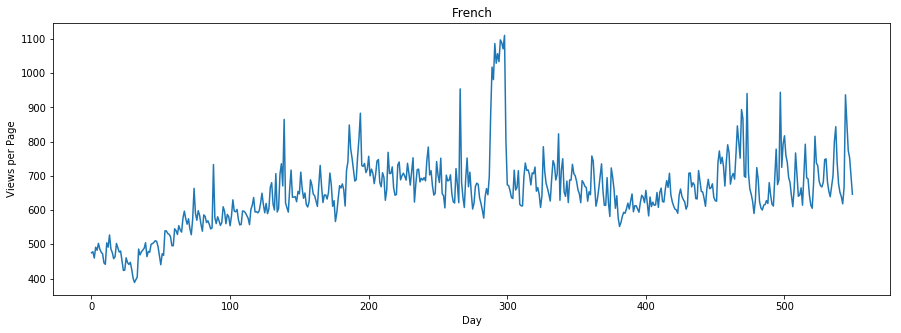

<Figure size 1080x360 with 0 Axes>

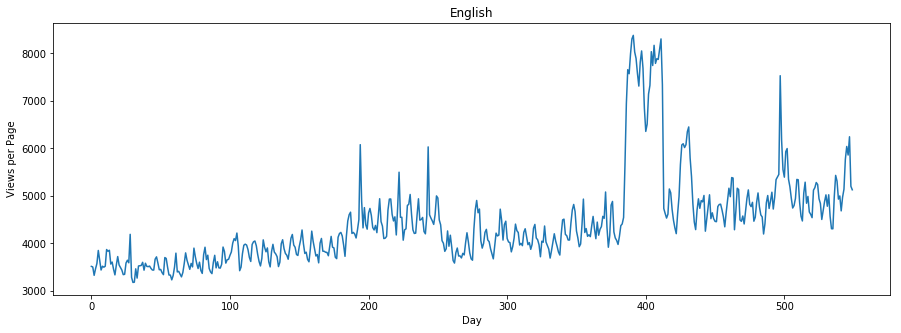

<Figure size 1080x360 with 0 Axes>

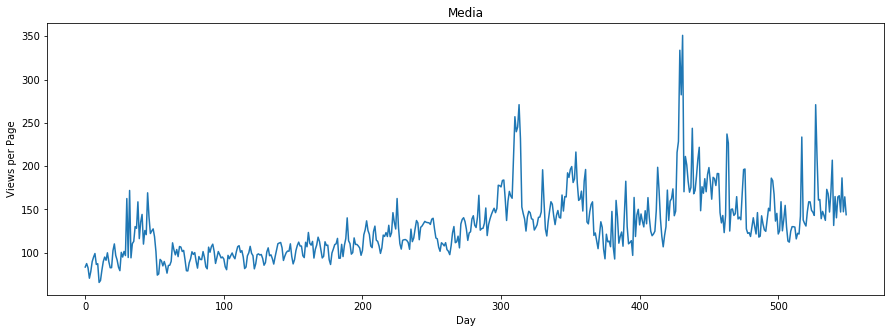

<Figure size 1080x360 with 0 Axes>

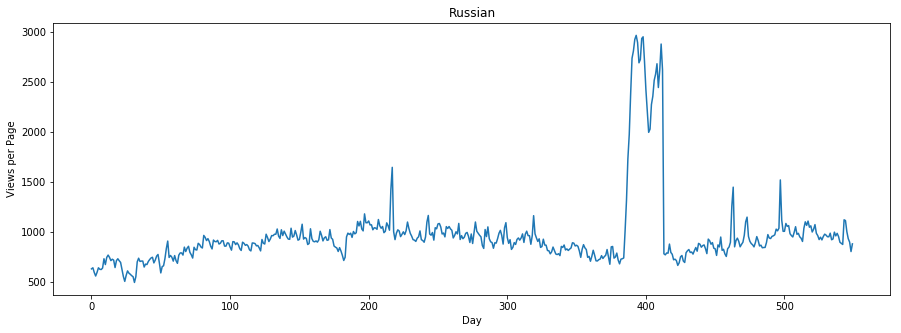

<Figure size 1080x360 with 0 Axes>

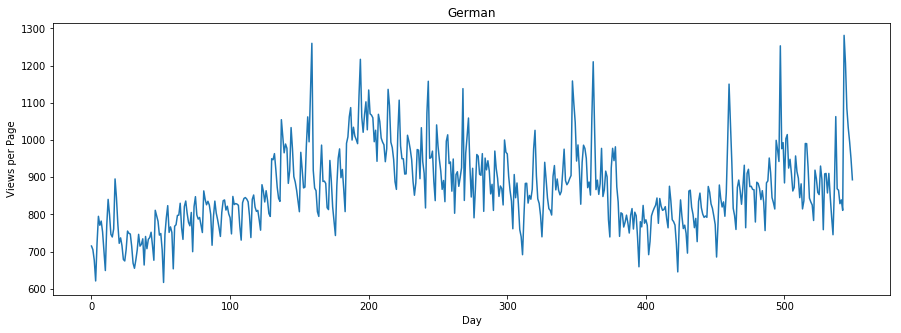

<Figure size 1080x360 with 0 Axes>

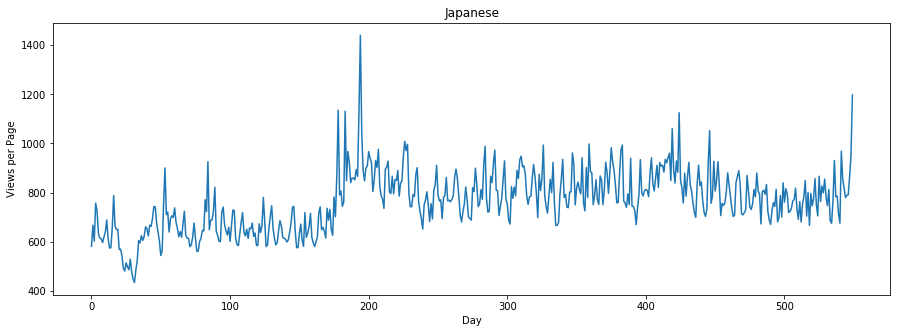

<Figure size 1080x360 with 0 Axes>

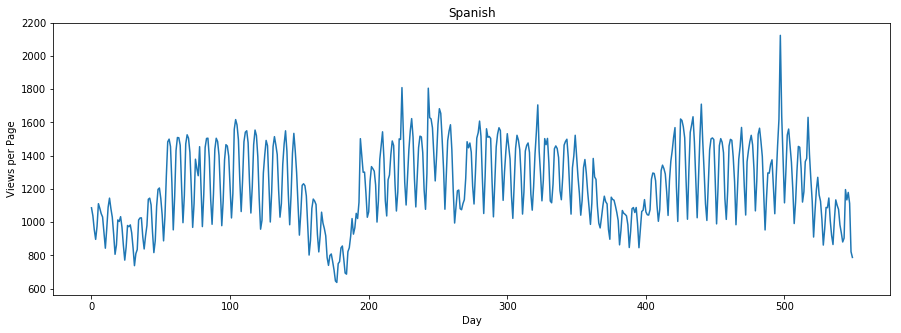

<Figure size 1080x360 with 0 Axes>

In [9]:
def plot_with_fft(key):
    fig = plt.figure(1, figsize=[15, 5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days, sums[key], label=labels[key])

    fig = plt.figure(2, figsize=[15,5])

    plt.show()

for key in sums:
    plot_with_fft(key)

<h3>Display top five websites for each language</h3>

In [10]:
npages = 5
top_pages = {}
for key in lang_sets:
    print(labels[key])
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(npages))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

Chinese
                                                     Page      total
28727   Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  123694312
61350    Wikipedia:首页_zh.wikipedia.org_desktop_all-agents   66435641
105844  Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...   50887429
28728   Special:搜索_zh.wikipedia.org_all-access_all-agents   48678124
61351      Special:搜索_zh.wikipedia.org_desktop_all-agents   48203843



French
                                                    Page      total
27330  Wikipédia:Accueil_principal_fr.wikipedia.org_a...  868480667
55104  Wikipédia:Accueil_principal_fr.wikipedia.org_m...  611302821
7344   Wikipédia:Accueil_principal_fr.wikipedia.org_d...  239589012
27825  Spécial:Recherche_fr.wikipedia.org_all-access_...   95666374
8221   Spécial:Recherche_fr.wikipedia.org_desktop_all...   88448938



English
                                                    Page        total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  12066181102
9774     

<h3>Get list of date column headers. Create function to return list of websites that contain certain words</h3>

In [11]:
cols = df_train.columns[1:-1]

def filter_df(df, word):
    df_new = df[df['Page'].str.contains(word)]
    apple_pages = df_new.Page.values
    df_new = df_new[cols].transpose()
    df_new[word] = df_new.values.sum(axis=1)
    return df_new[[word]]

<h3>Create list of four companies. Create empty dataframe. For each company name plot number of visits and max date in dataset.</h3>

Apple_Inc    2016-02-12
Microsoft    2016-04-06
Facebook     2016-08-23
Google       2016-08-23
dtype: object


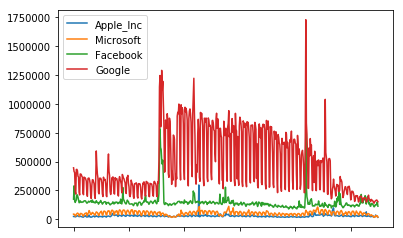

In [12]:
word_to_filter_by = ['Apple_Inc', 'Microsoft', 'Facebook', 'Google']

df_companies = pd.DataFrame()
for word in word_to_filter_by:
    df_tmp = filter_df(df_train, word)
    df_companies = pd.concat([df_companies, df_tmp], axis=1)

print(df_companies.idxmax(axis=0))
df_companies.plot()

<h3>Plot moving average of site visits for the four companies listed over 7 periods/days</h3>

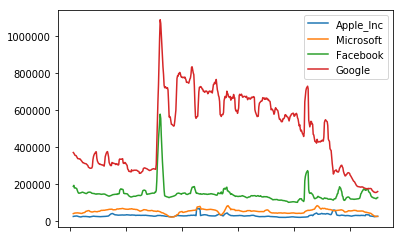

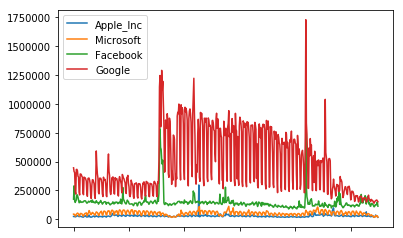

In [13]:
def moving_average_approach(df):
    moving_avg = df.rolling(window=7).mean()
    return moving_avg

moving_average_approach(df_companies).plot()
df_companies.plot()

<h3>Apply prophet and produce timeseries plots for observations, whole period trend, annual trend and weekly trend.
Also produce a two forecast and plot with observations</h3>

C:\Users\matth\Anaconda3\lib\site-packages\pystan\misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
C:\Users\matth\Anaconda3\lib\site-packages\fbprophet\forecaster.py:1008: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
C:\Users\matth\Anaconda3\lib\site-packages\fbprophet\forecaster.py:1132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


Apple_Inc


<Figure size 720x720 with 0 Axes>

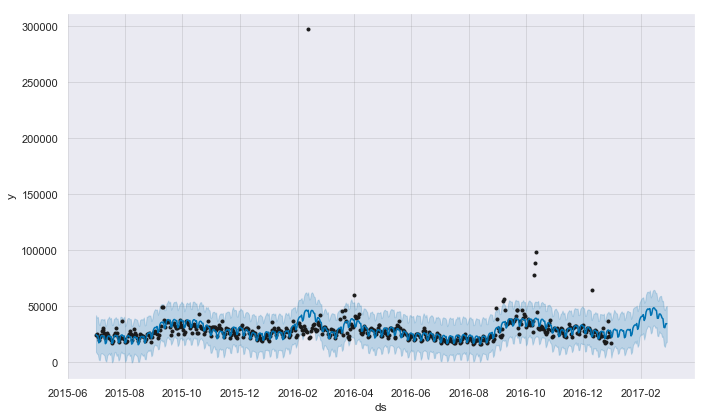

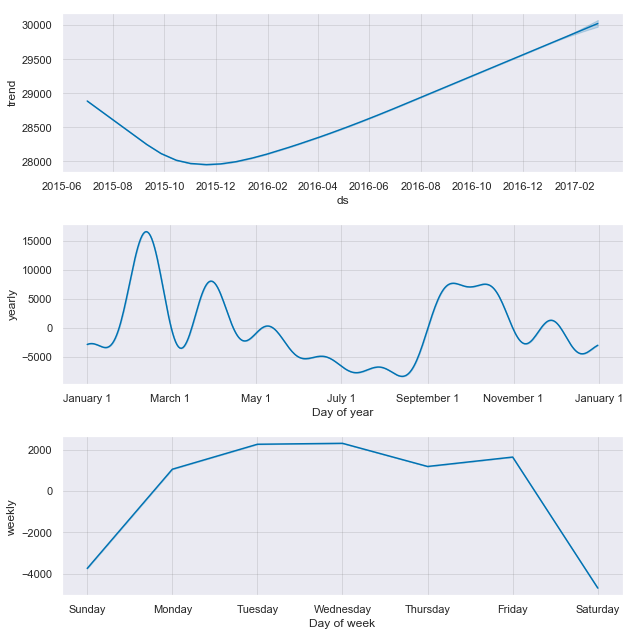

Microsoft


<Figure size 720x720 with 0 Axes>

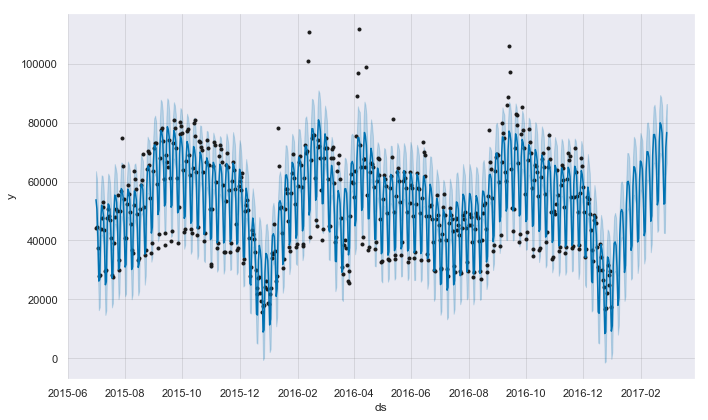

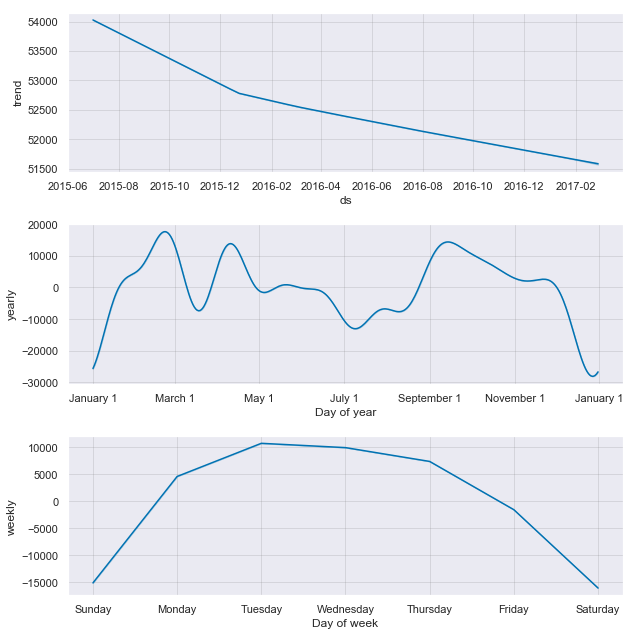

Facebook


<Figure size 720x720 with 0 Axes>

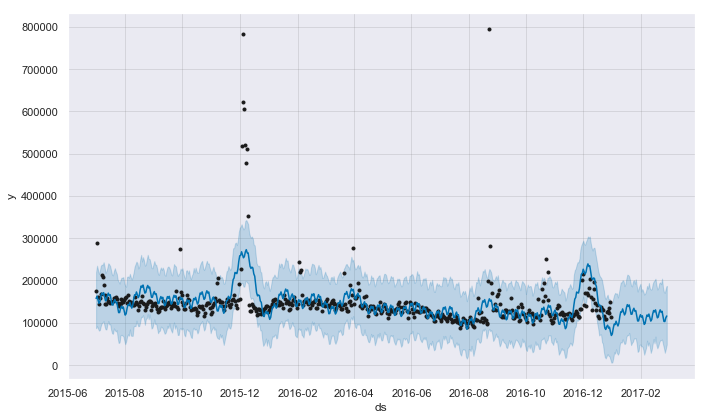

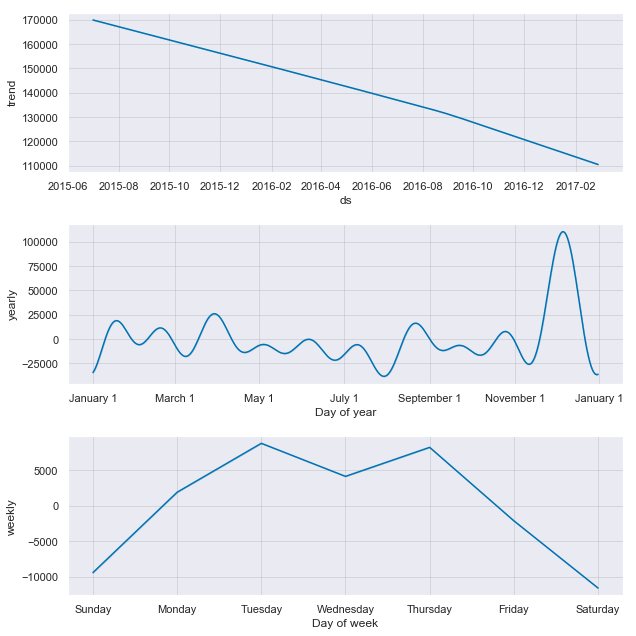

Google


<Figure size 720x720 with 0 Axes>

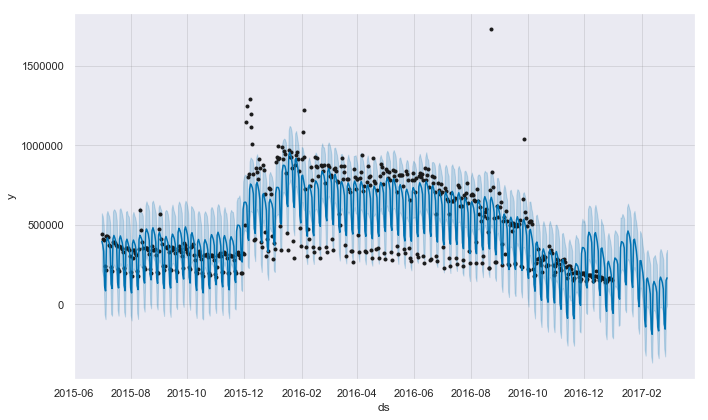

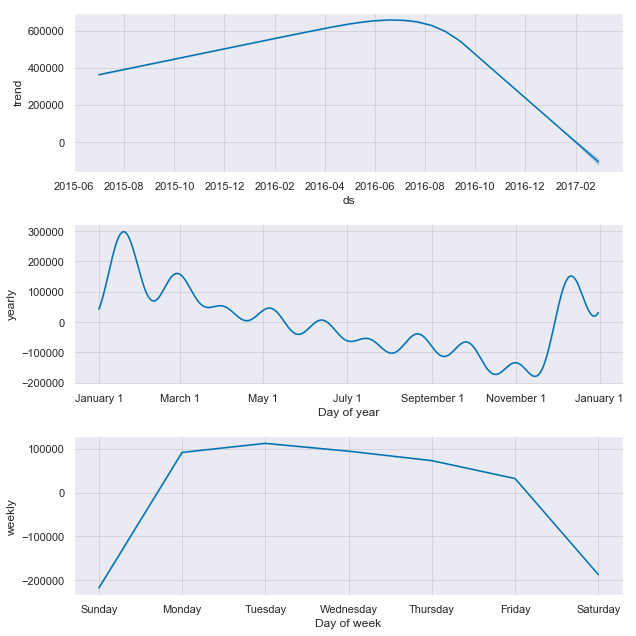

In [19]:
sns.set(font_scale=1) 

def make_forecast_with_prophet(df):
    values = df.values
    df_prophet = pd.DataFrame(list(zip(cols,values)), columns=['ds', 'y'])

    m = Prophet(yearly_seasonality=True, daily_seasonality=False).fit(df_prophet)
    future = m.make_future_dataframe(periods=days_to_forecast,freq='D', include_history=True)
    forecast = m.predict(future)
    return forecast, m

if True:
    days_to_forecast = 31+28
    plot_on = True

    cols = df_train.columns[1:-1]
    for key in word_to_filter_by:
        df_tmp = df_companies[key].copy()

        forecast, m = make_forecast_with_prophet(df_tmp)

        if plot_on:
            plt.figure(figsize=(10, 10))
            fig = m.plot(forecast)
            fig = m.plot_components(forecast)
            print(key)
            plt.show()